# Análisis de retención de clientes mediante técnicas de aprendizaje automático - Modelo 1 
Lucia Canales Fischer


In [1]:
#!pip install pyodbc
#!pip install pandas 
#!pip install xgboost
#!pip install pandas openpyxl


In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyodbc

In [2]:
ruta = "C:\\Users\\lucia\\Downloads\\tesis\\modelo_1.xlsx"
devoluciones = pd.read_excel(ruta)

In [3]:
devoluciones['fechaingreso'] = pd.to_datetime(devoluciones['fechaingreso'])
devoluciones['mes_entrega_tarjeta'] = devoluciones['fechaingreso'].dt.month

In [4]:
devoluciones['fecha'] = pd.to_datetime(devoluciones['AñoMesIngreso'], format='%Y%m')
devoluciones['año'] = devoluciones['fecha'].dt.year
devoluciones['mes'] = devoluciones['fecha'].dt.month
devoluciones['log_ingresos'] = np.log(devoluciones['ingresos'])

# ONE HOT ENCODING

In [5]:
devoluciones_encoded = pd.get_dummies(devoluciones, columns=['Canal_ingreso', 'vuelta_clases','sexo', 'estado_civil','departamento','mes_entrega_tarjeta'])
devoluciones_encoded = devoluciones_encoded.drop(columns='cuenta')

# Definición de TRAIN y TEST

In [6]:
from sklearn.model_selection import train_test_split

X = devoluciones_encoded.drop(columns=['devuelta'])  
y = devoluciones_encoded['devuelta']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
eliminar_full = ['fechaingreso','fecha_nacimiento','id_estado_civil','año','mes', 'ingresos_inferidos',
                        'id_departamento','id_tipotrabajo','tipo_trabajo','FechaModificacion', 
                        'AñoMesModificacion','UltimoEstado','UltimoIdEstado','AñoMesIngreso', 
                        'fecha','log_ingresos', 'zona','vuelta_clases_no', 'vuelta_clases_si', 'ingresos'] 

In [8]:
X_train_full = X_train.drop(columns=eliminar_full)
X_test_full = X_test.drop(columns=eliminar_full)

# LOGISTICA 

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

logit_model = LogisticRegression()

logit_model.fit(X_train_full, y_train)

y_pred_log = logit_model.predict(X_test_full)

accuracy = accuracy_score(y_test, y_pred_log)

In [10]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import numpy as np

X_train_full = sm.add_constant(X_train_full)
X_test_full = sm.add_constant(X_test_full)

logit_model = sm.Logit(y_train, X_train_full)
result = logit_model.fit()

y_pred_log_prob = result.predict(X_test_full)
y_pred_log = np.where(y_pred_log_prob > 0.5, 1, 0) 

accuracy = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy)

print(result.summary())


C:\Users\lucia\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.182997
         Iterations 8
Accuracy: 0.9541462656407865
                           Logit Regression Results                           
Dep. Variable:               devuelta   No. Observations:                30022
Model:                          Logit   Df Residuals:                    29982
Method:                           MLE   Df Model:                           39
Date:                Mon, 25 Nov 2024   Pseudo R-squ.:                 0.04031
Time:                        20:34:06   Log-Likelihood:                -5493.9
converged:                       True   LL-Null:                       -5724.7
Covariance Type:            nonrobust   LLR p-value:                 1.255e-73
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -11.2576   2.09

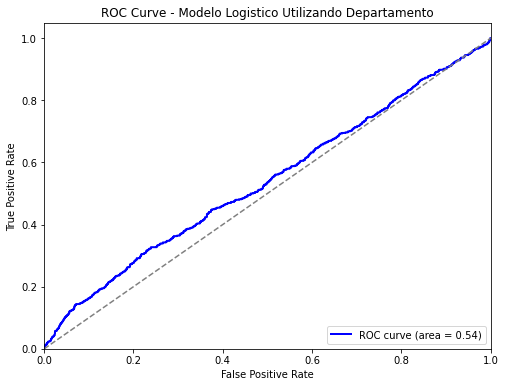

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


logit_model = LogisticRegression()
logit_model.fit(X_train_full, y_train)

y_pred_log = logit_model.predict(X_test_full)
y_prob_log = logit_model.predict_proba(X_test_full)[:, 1]

fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_log)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Modelo Logistico Utilizando Departamento')
plt.legend(loc='lower right')
plt.show()

In [12]:
y_prob_log = logit_model.predict_proba(X_test_full)[:, 1]
y_pred_log = (y_prob_log > 0.5).astype(int)

result_log = pd.DataFrame({'y_prob': y_prob_log, 'y_pred': y_pred_log}, index=X_test_full.index)
result_log

,y_prob,y_pred
16695,0.030323,0
40222,0.032414,0
33953,0.029377,0
42452,0.033388,0
18606,0.033675,0
...,...,...
26626,0.031553,0
6494,0.065177,0
3234,0.033323,0
28370,0.037286,0


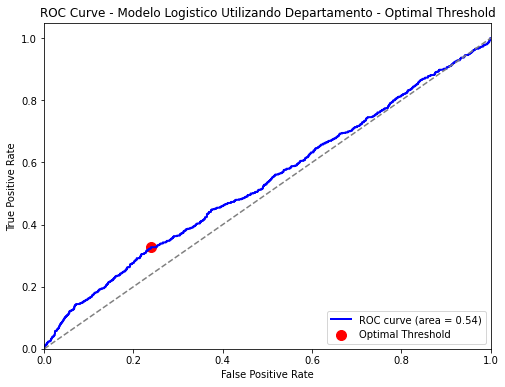

Optimal Threshold: 0.06450223903397469


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_log = logit_model.predict_proba(X_test_full)[:, 1]

fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_prob_log)

auc_log = roc_auc_score(y_test, y_prob_log)

Youden_index_log = tpr_log - fpr_log
optimal_threshold_index_log = np.argmax(Youden_index_log)
optimal_threshold_log = thresholds_log[optimal_threshold_index_log]

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_log)
plt.scatter(fpr_log[optimal_threshold_index_log]
            , tpr_log[optimal_threshold_index_log]
            , color='red', s=100, label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Modelo Logistico Utilizando Departamento - Optimal Threshold')
plt.legend(loc='lower right')
plt.show()

print("Optimal Threshold:", optimal_threshold_log)

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred_optimal_threshold_log = (y_prob_log >= optimal_threshold_log).astype(int)

conf_matrix_log = confusion_matrix(y_test, y_pred_optimal_threshold_log)

print("Matriz de confusión:")
print(conf_matrix_log)

Matriz de confusión:
[[9342 2935]
 [ 397  193]]


In [16]:
fn_index_row = 1  
fn_index_col = 0 
fn_count = conf_matrix_log[fn_index_row, fn_index_col]

print("Falsos Negativos (FN):", fn_count)

Falsos Negativos (FN): 397


In [17]:
y_prob_log = logit_model.predict_proba(X_test_full)[:, 1]
y_pred_log = (y_prob_log > 0.5).astype(int)
y_pred_optimal_threshold_log = (y_prob_log >= optimal_threshold_log).astype(int)

result_log = pd.DataFrame({'y_prob': y_prob_log,
                              'y_pred': y_pred_log,
                             'y_pred_OT' : y_pred_optimal_threshold_log
                             }, index=X_test_full.index)
result_log

,y_prob,y_pred,y_pred_OT
16695,0.030323,0,0
40222,0.032414,0,0
33953,0.029377,0,0
42452,0.033388,0,0
18606,0.033675,0,0
...,...,...,...
26626,0.031553,0,0
6494,0.065177,0,1
3234,0.033323,0,0
28370,0.037286,0,0


In [19]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real_log, y_proba_log):
    df = pd.DataFrame()
    df['real'] = y_real_log
    df['proba'] = y_proba_log
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'], df['proba'])
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    return ks.statistic, roc_auc

print("Log model:")
ks_base_log, auc_base_log = evaluate_ks_and_roc_auc(y_test, y_prob_log)

Log model:
KS: 0.0881 (p-value: 3.012e-04)
ROC AUC: 0.5381


In [20]:
results_df_log = pd.DataFrame({
    'Modelo': ['Logistico'],
    'KS': [ks_base_log],
    'ROC AUC': [auc_base_log]
})
results_df_log = results_df_log.round(3)
results_df_log

,Modelo,KS,ROC AUC
0,Logistico,0.088,0.538


# Random forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier()

rf_model.fit(X_train_full, y_train)

y_pred_rf = rf_model.predict(X_test_full)

accuracy = accuracy_score(y_test, y_pred_rf)

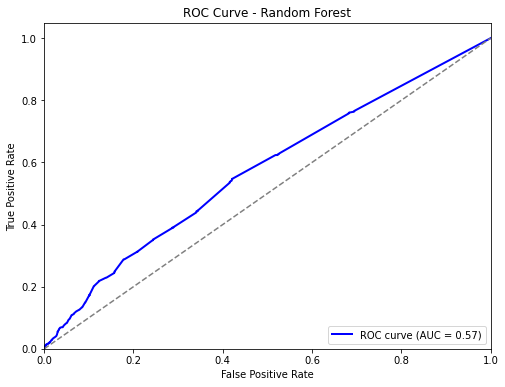

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_rf = rf_model.predict_proba(X_test_full)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

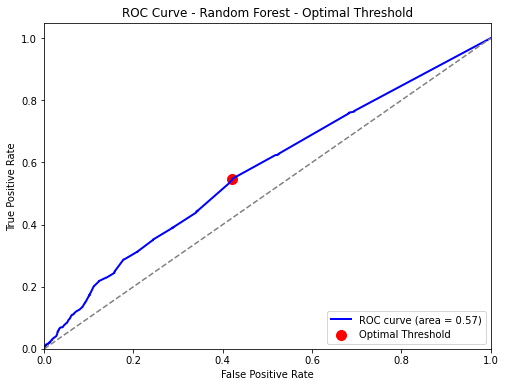

Optimal Threshold: 0.02083333333333333


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_rf = rf_model.predict_proba(X_test_full)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)

auc_rf = roc_auc_score(y_test, y_prob_rf)

Youden_index_rf = tpr_rf - fpr_rf
optimal_threshold_index_rf = np.argmax(Youden_index_rf)
optimal_threshold_rf = thresholds_rf[optimal_threshold_index_rf]

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_rf)
plt.scatter(fpr_rf[optimal_threshold_index_rf], tpr_rf[optimal_threshold_index_rf], color='red', s=100
            , label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - Optimal Threshold')
plt.legend(loc='lower right')
plt.show()

print("Optimal Threshold:", optimal_threshold_rf)

In [25]:
y_prob_rf = rf_model.predict_proba(X_test_full)[:, 1]
y_pred_rf = rf_model.predict(X_test_full)
y_pred_optimal_rf = (y_prob_rf >= optimal_threshold_rf).astype(int)


result_df = pd.DataFrame({'y_prob': y_prob_rf, 'y_pred': y_pred_rf, 'y_pred_OT':y_pred_optimal_rf }, index=X_test_full.index)
result_df

,y_prob,y_pred,y_pred_OT
16695,0.00,0,0
40222,0.00,0,0
33953,0.12,0,1
42452,0.00,0,0
18606,0.00,0,0
...,...,...,...
26626,0.04,0,1
6494,0.01,0,0
3234,0.00,0,0
28370,0.01,0,0


In [27]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real_rf, y_proba_rf):
    df = pd.DataFrame()
    df['real'] = y_real_rf
    df['proba'] = y_proba_rf
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'], df['proba'])
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    return ks.statistic, roc_auc

print("RF model:")
ks_rf, auc_rf = evaluate_ks_and_roc_auc(y_test, y_prob_rf)

RF model:
KS: 0.1263 (p-value: 2.712e-08)
ROC AUC: 0.5741


In [28]:
results_df_rf = pd.DataFrame({
    'Modelo': ['Random Forest'],
    'KS': [ks_rf],
    'ROC AUC': [auc_rf]
})


results_resumen = pd.concat([results_df_log, results_df_rf], ignore_index=True)
results_resumen = results_resumen.round(3)
results_resumen

,Modelo,KS,ROC AUC
0,Logistico,0.088,0.538
1,Random Forest,0.126,0.574


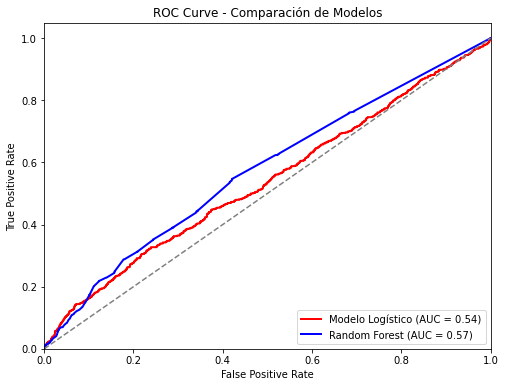

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC - Modelo Logístico 
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='red', lw=2, label='Modelo Logístico (AUC = %0.2f)' % auc_log)

# Curva ROC - Random Forest
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % auc_rf)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Comparación de Modelos')
plt.legend(loc='lower right')
plt.show()


# XG BOOST

In [38]:
#pip install xgboost

In [30]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train_full, y_train)

y_pred_xgb = xgb_model.predict(X_test_full)

accuracy = accuracy_score(y_test, y_pred_xgb)

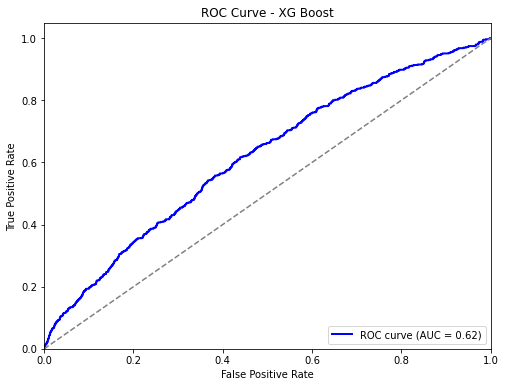

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_xgb = xgb_model.predict_proba(X_test_full)[:, 1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)

auc_xgb = roc_auc_score(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_xgb)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XG Boost')
plt.legend(loc='lower right')
plt.show()

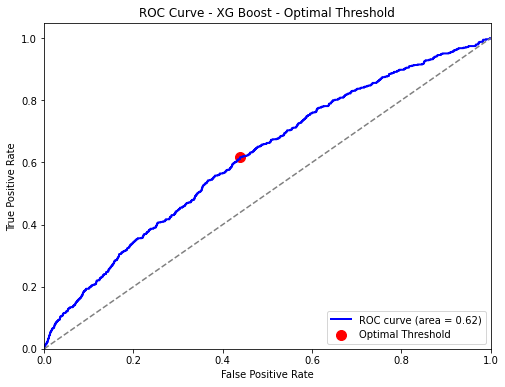

Optimal Threshold: 0.03594058


In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_xgb = xgb_model.predict_proba(X_test_full)[:, 1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)

auc_xgb = roc_auc_score(y_test, y_prob_xgb)

Youden_index_xgb = tpr_xgb - fpr_xgb
optimal_threshold_index_xgb = np.argmax(Youden_index_xgb)
optimal_threshold_xgb = thresholds_xgb[optimal_threshold_index_xgb]

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_xgb)
plt.scatter(fpr_xgb[optimal_threshold_index_xgb], tpr_xgb[optimal_threshold_index_xgb], color='red', s=100, label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XG Boost - Optimal Threshold')
plt.legend(loc='lower right')
plt.show()

print("Optimal Threshold:", optimal_threshold_xgb)

In [33]:
from sklearn.metrics import confusion_matrix

y_prob_xgb = xgb_model.predict_proba(X_test_full)[:, 1]

y_pred_optimal_xgb = (y_prob_xgb >= optimal_threshold_xgb).astype(int)

conf_matrix_xgb = confusion_matrix(y_test, y_pred_optimal_xgb)

print("Matriz de Confusión:")
print(conf_matrix_xgb)

Matriz de Confusión:
[[6885 5392]
 [ 226  364]]


In [34]:
y_prob_xgb = xgb_model.predict_proba(X_test_full)[:, 1]
y_pred_xgb = xgb_model.predict(X_test_full)
y_pred_optimal_xgb = (y_prob_xgb >= optimal_threshold_xgb).astype(int)


result_df = pd.DataFrame({'y_prob': y_prob_xgb, 'y_pred': y_pred_xgb, 'y_pred_OT':y_pred_optimal_xgb }, index=X_test_full.index)
result_df

,y_prob,y_pred,y_pred_OT
16695,0.011289,0,0
40222,0.013166,0,0
33953,0.029636,0,0
42452,0.010588,0,0
18606,0.074295,0,1
...,...,...,...
26626,0.071291,0,1
6494,0.031533,0,0
3234,0.018844,0,0
28370,0.028704,0,0


In [35]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real_xgb, y_proba_xgb):
    df = pd.DataFrame()
    df['real'] = y_real_xgb
    df['proba'] = y_proba_xgb
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'], df['proba'])
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    return ks.statistic, roc_auc

print("xgb model:")
ks_xgb, auc_xgb = evaluate_ks_and_roc_auc(y_test, y_prob_xgb)

xgb model:
KS: 0.1778 (p-value: 4.940e-16)
ROC AUC: 0.6170


In [36]:
results_df_xgb = pd.DataFrame({
    'Modelo': ['XGBoost'],
    'KS': [ks_xgb],
    'ROC AUC': [auc_xgb]
})

results_resumen = pd.concat([results_df_log, results_df_rf,results_df_xgb ], ignore_index=True)
results_resumen = results_resumen.round(3)
results_resumen

,Modelo,KS,ROC AUC
0,Logistico,0.088,0.538
1,Random Forest,0.126,0.574
2,XGBoost,0.178,0.617


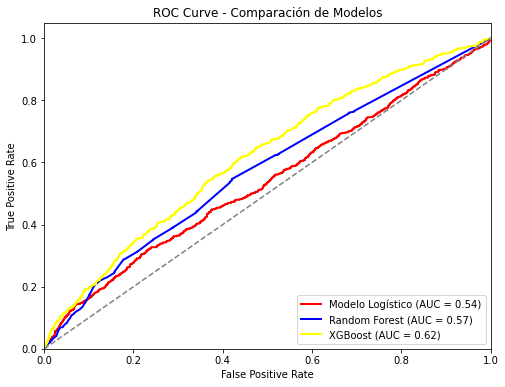

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC - Modelo Logístico
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='red', lw=2, label='Modelo Logístico (AUC = %0.2f)' % auc_log)

# Curva ROC - Random Forest
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % auc_rf)

#Curva ROC - XGBoost
plt.plot(fpr_xgb, tpr_xgb, color='yellow', lw=2, label='XGBoost (AUC = %0.2f)' % auc_xgb)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Comparación de Modelos')
plt.legend(loc='lower right')
plt.show()

# LOGISTICA con STEPWISE 

In [38]:
X_train_full = X_train_full.drop(columns='const')
X_test_full = X_test_full.drop(columns='const')

In [39]:
#pip install mlxtend

In [40]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

logit_model_SW = LogisticRegression(max_iter=1000)

sfs = SFS(logit_model_SW, 
          k_features='best', 
          forward=True, 
          floating=False, 
          verbose=2,
          scoring='roc_auc',
          cv=5)

sfs = sfs.fit(X_train_scaled, y_train)

selected_features = list(sfs.k_feature_names_)
print("Características seleccionadas:", selected_features)

logit_model_SFS = LogisticRegression(max_iter=1000).fit(X_train_scaled[:, sfs.k_feature_idx_], y_train)
print("Coeficientes del modelo final:", logit_model_SFS.coef_)

y_pred_logitSFS = logit_model_SFS.predict(X_test_scaled[:, sfs.k_feature_idx_])

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.0s

[2024-11-25 20:35:56] Features: 1/44 -- score: 0.610328541084564[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.3s

[2024-11-25 20:36:04] Features: 2/44 -- score: 0.6228335385272005[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    8.8s

[2024-11-25 20:36:13] Features: 3/44 -- score: 0.633627348065821[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.0s

[2024-11-25 20:36:23] Features: 4/44 -- score: 0.6391939313157808[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   10.8s

[2024-11-25 20:36:34] Features: 5/44 -- score: 0.644486036233349
[2024-11-25 20:36:45] Features: 6/44 -- score: 0.6477008802600908
[2024-11-25 20:36:55] Features: 7/44 -- score: 0.6501463529058044
[2024-11-25 20:37:05] Features: 8/44 -- score: 0.6520442413097157
[2024-11-25 20:37:15] Features: 9/44 -- score: 0.6535694080135334
[2024-11-25 20:37:25] Features: 10/44 -- s

Características seleccionadas: ['0', '1', '2', '3', '5', '14', '21', '22', '24', '25', '31', '32', '33', '35', '37', '41', '42', '43']
Coeficientes del modelo final: [[ 0.3504197  -0.05562716  0.2112491   0.07415163  0.03030127  0.08995529
   0.08051633  0.14099138 -0.10656653 -0.11073649 -0.09248598 -0.29738546
  -0.20983529 -0.03173396 -0.0531487   0.0446569   0.05223912  0.0757671 ]]



[2024-11-25 20:40:56] Features: 44/44 -- score: 0.6461766874711647

In [42]:
feature_names = X_train_full.columns

selected_coefs = logit_model_SFS.coef_[0]
selected_indices = [int(index) for index in selected_features]
selected_coef_df = pd.DataFrame({'Variable': feature_names[selected_indices], 'Coeficiente': selected_coefs})
selected_coef_df

,Variable,Coeficiente
0,edad_solicitud,0.350420
1,LimiteCredito,-0.055627
2,Canal_ingreso_Call Center,0.211249
3,Canal_ingreso_Red,0.074152
4,sexo_F,0.030301
5,departamento_Canelones,0.089955
6,departamento_Maldonado,0.080516
7,departamento_Montevideo,0.140991
8,departamento_Rivera,-0.106567
9,departamento_Rocha,-0.110736


In [43]:
selected_features_names = [feature_names[index] for index in selected_indices]

print("Variables seleccionadas:", selected_features_names)

Variables seleccionadas: ['edad_solicitud', 'LimiteCredito', 'Canal_ingreso_Call Center', 'Canal_ingreso_Red', 'sexo_F', 'departamento_Canelones', 'departamento_Maldonado', 'departamento_Montevideo', 'departamento_Rivera', 'departamento_Rocha', 'departamento_Treinta y Tres', 'mes_entrega_tarjeta_1', 'mes_entrega_tarjeta_2', 'mes_entrega_tarjeta_4', 'mes_entrega_tarjeta_6', 'mes_entrega_tarjeta_10', 'mes_entrega_tarjeta_11', 'mes_entrega_tarjeta_12']


# MODELOS REDUCIDOS

In [44]:
eliminar_reducido = ['fechaingreso','fecha_nacimiento','id_estado_civil',
                        'id_departamento','id_tipotrabajo','tipo_trabajo','FechaModificacion', 'AñoMesModificacion',
                        'UltimoEstado','UltimoIdEstado','AñoMesIngreso', 'fecha','log_ingresos', 'zona',
                        'ingresos_inferidos', 'ingresos','año', 'mes','estado_civil_Casado', 'estado_civil_Divorciado',
                         'estado_civil_Separado', 'estado_civil_Soltero', 'estado_civil_Unión Libre', 'estado_civil_Viudo',
                        'mes_entrega_tarjeta_1', 'mes_entrega_tarjeta_2', 'mes_entrega_tarjeta_3','mes_entrega_tarjeta_4',
                         'mes_entrega_tarjeta_5', 'mes_entrega_tarjeta_6', 'mes_entrega_tarjeta_7','mes_entrega_tarjeta_8',
                         'mes_entrega_tarjeta_9', 'mes_entrega_tarjeta_10', 'mes_entrega_tarjeta_11','mes_entrega_tarjeta_12'] 

In [45]:
X_train_reducido = X_train.drop(columns=eliminar_reducido)
X_test_reducido = X_test.drop(columns=eliminar_reducido)

# Logistica

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

logit_model_red = LogisticRegression(max_iter=1000) #max_iter=1000, C=1.0

logit_model_red.fit(X_train_reducido, y_train)

y_pred_log_red = logit_model_red.predict(X_test_reducido)

accuracy_red = accuracy_score(y_test, y_pred_log_red)

In [47]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import numpy as np

X_train_reducido = sm.add_constant(X_train_reducido)
X_test_reducido = sm.add_constant(X_test_reducido)

logit_model_red = sm.Logit(y_train, X_train_reducido)
result_red = logit_model_red.fit()

y_pred_log_prob_red = result_red.predict(X_test_reducido)
y_pred_log_red = np.where(y_pred_log_prob_red > 0.5, 1, 0) 

accuracy = accuracy_score(y_test, y_pred_log_red)
print("Accuracy:", accuracy)

print(result_red.summary())


Optimization terminated successfully.
         Current function value: 0.184988
         Iterations 8
Accuracy: 0.9541462656407865
                           Logit Regression Results                           
Dep. Variable:               devuelta   No. Observations:                30022
Model:                          Logit   Df Residuals:                    29997
Method:                           MLE   Df Model:                           24
Date:                Mon, 25 Nov 2024   Pseudo R-squ.:                 0.02987
Time:                        20:43:49   Log-Likelihood:                -5553.7
converged:                       True   LL-Null:                       -5724.7
Covariance Type:            nonrobust   LLR p-value:                 5.484e-58
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.6450   1.12

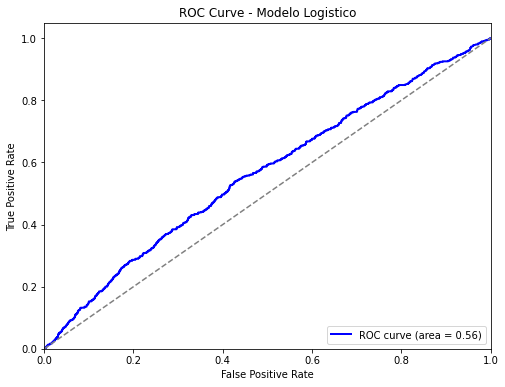

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

logit_model_red = LogisticRegression(max_iter=1000)
logit_model_red.fit(X_train_reducido, y_train)

y_pred_log_red = logit_model_red.predict(X_test_reducido)
y_prob_log_red = logit_model_red.predict_proba(X_test_reducido)[:, 1]

fpr_log_red, tpr_log_red, thresholds_log_red = roc_curve(y_test, y_prob_log_red)
auc_log_red = roc_auc_score(y_test, y_prob_log_red)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_red, tpr_log_red, color='blue'
         , lw=2, label='ROC curve (area = %0.2f)' % auc_log_red)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Modelo Logistico')
plt.legend(loc='lower right')
plt.show()

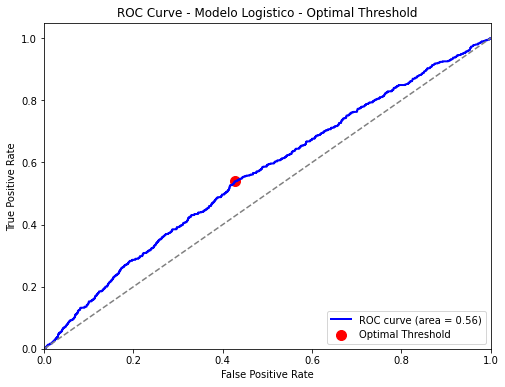

Optimal Threshold: 0.0335652411474682


In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_log_red = logit_model_red.predict_proba(X_test_reducido)[:, 1]

fpr_log_red, tpr_log_red, thresholds_log_red = roc_curve(y_test, y_prob_log_red)

auc_log_red = roc_auc_score(y_test, y_prob_log_red)

Youden_index_log_red = tpr_log_red - fpr_log_red
optimal_threshold_index_log_red = np.argmax(Youden_index_log_red)
optimal_threshold_log_red = thresholds_log[optimal_threshold_index_log_red]

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_red, tpr_log_red, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_log_red)
plt.scatter(fpr_log_red[optimal_threshold_index_log_red]
            , tpr_log_red[optimal_threshold_index_log_red]
            , color='red', s=100, label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Modelo Logistico - Optimal Threshold')
plt.legend(loc='lower right')
plt.show()

print("Optimal Threshold:", optimal_threshold_log_red)

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_pred_optimal_threshold_log_red = (y_prob_log_red >= optimal_threshold_log_red).astype(int)

conf_matrix_log_red = confusion_matrix(y_test, y_pred_optimal_threshold_log_red)

print("Matriz de confusión:")
print(conf_matrix_log_red)

Matriz de confusión:
[[4642 7635]
 [ 180  410]]


In [51]:
fn_index_row = 1  
fn_index_col = 0 
fn_count = conf_matrix_log_red[fn_index_row, fn_index_col]

print("Falsos Negativos (FN):", fn_count)

Falsos Negativos (FN): 180


In [52]:
y_prob_log_red = logit_model_red.predict_proba(X_test_reducido)[:, 1]
y_pred_log_red = (y_prob_log_red > 0.5).astype(int)
y_pred_optimal_threshold_log_red = (y_prob_log_red >= optimal_threshold_log_red).astype(int)

result_log_red = pd.DataFrame({'y_prob': y_prob_log_red,
                              'y_pred': y_pred_log_red,
                             'y_pred_OT' : y_pred_optimal_threshold_log_red
                             }, index=X_test_reducido.index)
result_log_red

,y_prob,y_pred,y_pred_OT
16695,0.050284,0,1
40222,0.024505,0,0
33953,0.023938,0,0
42452,0.024991,0,0
18606,0.042693,0,1
...,...,...,...
26626,0.034179,0,1
6494,0.097337,0,1
3234,0.027342,0,0
28370,0.030460,0,0


In [53]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc_red(y_real_log_red, y_proba_log_red):
    df_red = pd.DataFrame()
    df_red['real'] = y_real_log_red
    df_red['proba'] = y_proba_log_red
    class0 = df_red[df_red['real'] == 0]
    class1 = df_red[df_red['real'] == 1]
    ks_red = ks_2samp(class0['proba'], class1['proba'])
    roc_auc_red = roc_auc_score(df_red['real'], df_red['proba'])
    print(f"KS: {ks_red.statistic:.4f} (p-value: {ks_red.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc_red:.4f}")
    return ks_red.statistic, roc_auc_red

print("log_red model:")
ks_base_log_red, auc_base_log_red = evaluate_ks_and_roc_auc_red(y_test, y_prob_log_red)

log_red model:
KS: 0.1122 (p-value: 1.261e-06)
ROC AUC: 0.5633


In [54]:
results_df_log_red = pd.DataFrame({
    'Modelo': ['Logistico Reducido'],
    'KS': [ks_base_log_red],
    'ROC AUC': [auc_base_log_red]
})

results_df_log_red = results_df_log_red.round(3)
results_df_log_red

,Modelo,KS,ROC AUC
0,Logistico Reducido,0.112,0.563


# Random forest

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model_red = RandomForestClassifier()

rf_model_red.fit(X_train_reducido, y_train)

y_pred_rf_red = rf_model_red.predict(X_test_reducido)

accuracy = accuracy_score(y_test, y_pred_rf_red)

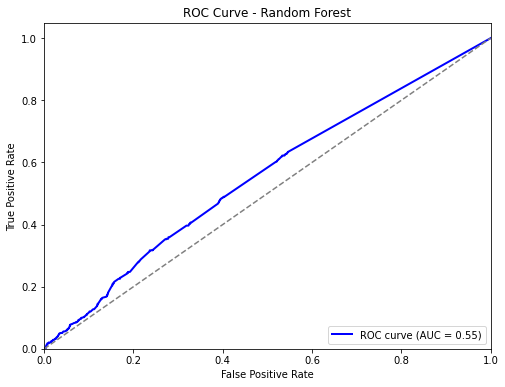

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_rf_red = rf_model_red.predict_proba(X_test_reducido)[:, 1]
fpr_rf_red, tpr_rf_red, thresholds_rf_red = roc_curve(y_test, y_prob_rf_red)
auc_rf_red = roc_auc_score(y_test, y_prob_rf_red)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_red, tpr_rf_red, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_rf_red)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

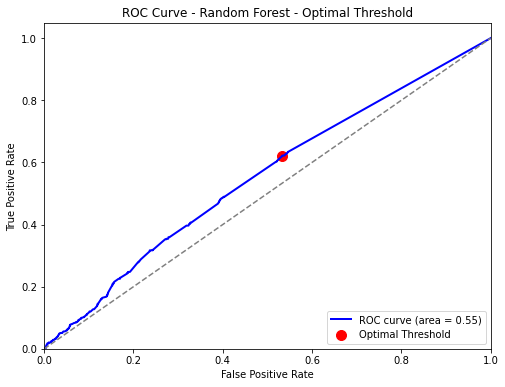

Optimal Threshold: 0.003928571428571429


In [57]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_rf_red = rf_model_red.predict_proba(X_test_reducido)[:, 1]

fpr_rf_red, tpr_rf_red, thresholds_rf_red = roc_curve(y_test, y_prob_rf_red)

auc_rf_red = roc_auc_score(y_test, y_prob_rf_red)

Youden_index_rf_red = tpr_rf_red - fpr_rf_red
optimal_threshold_index_rf_red = np.argmax(Youden_index_rf_red)
optimal_threshold_rf_red = thresholds_rf_red[optimal_threshold_index_rf_red]

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_red, tpr_rf_red, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_rf_red)
plt.scatter(fpr_rf_red[optimal_threshold_index_rf_red], tpr_rf_red[optimal_threshold_index_rf_red], color='red', s=100
            , label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - Optimal Threshold')
plt.legend(loc='lower right')
plt.show()

print("Optimal Threshold:", optimal_threshold_rf_red)

In [58]:
from sklearn.metrics import confusion_matrix

y_prob_rf_red = rf_model_red.predict_proba(X_test_reducido)[:, 1]

y_pred_optimal_rf_red = (y_prob_rf >= optimal_threshold_rf_red).astype(int)

conf_matrix_rf_red = confusion_matrix(y_test, y_pred_optimal_rf_red)

print("Matriz de Confusión:")
print(conf_matrix_rf_red)

Matriz de Confusión:
[[3790 8487]
 [ 140  450]]


In [59]:
y_prob_rf_red = rf_model_red.predict_proba(X_test_reducido)[:, 1]
y_pred_rf_red = rf_model_red.predict(X_test_reducido)
y_pred_optimal_rf_red = (y_prob_rf_red >= optimal_threshold_rf_red).astype(int)


result_df_red = pd.DataFrame({'y_prob': y_prob_rf_red, 'y_pred': y_pred_rf_red, 'y_pred_OT':y_pred_optimal_rf_red }, index=X_test.index)
result_df_red


,y_prob,y_pred,y_pred_OT
16695,0.00,0,0
40222,0.00,0,0
33953,0.01,0,1
42452,0.00,0,0
18606,0.00,0,0
...,...,...,...
26626,0.02,0,1
6494,0.01,0,1
3234,0.00,0,0
28370,0.00,0,0


In [60]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real_rf_red, y_proba_rf_red):
    df = pd.DataFrame()
    df['real'] = y_real_rf_red
    df['proba'] = y_proba_rf_red
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'], df['proba'])
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    return ks.statistic, roc_auc

print("RF model:")
ks_rf_red, auc_rf_red = evaluate_ks_and_roc_auc(y_test, y_prob_rf_red)

RF model:
KS: 0.0888 (p-value: 2.614e-04)
ROC AUC: 0.5531


In [61]:
results_df_rf_red = pd.DataFrame({
    'Modelo': ['Random Forest Reducido'],
    'KS': [ks_rf_red],
    'ROC AUC': [auc_rf_red]
})

results_resumen_red = pd.concat([results_df_log_red, results_df_rf_red], ignore_index=True)
results_resumen_red = results_resumen_red.round(3)
results_resumen_red

,Modelo,KS,ROC AUC
0,Logistico Reducido,0.112,0.563
1,Random Forest Reducido,0.089,0.553


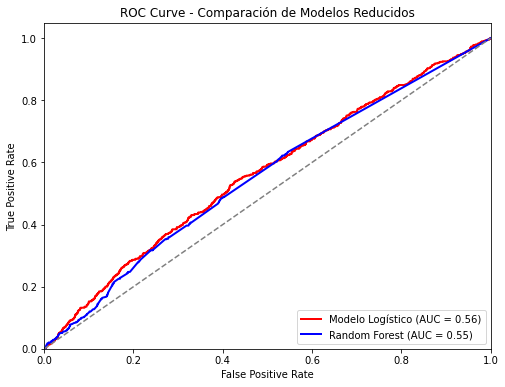

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC - Modelo Logístico (SFS)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_red, tpr_log_red, color='red', lw=2
         , label='Modelo Logístico (AUC = %0.2f)' % auc_log_red)

# Curva ROC - Random Forest
plt.plot(fpr_rf_red, tpr_rf_red, color='blue', lw=2
         , label='Random Forest (AUC = %0.2f)' % auc_rf_red)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Comparación de Modelos Reducidos')
plt.legend(loc='lower right')
plt.show()

# XG BOOST

In [63]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model_red = xgb.XGBClassifier()

xgb_model_red.fit(X_train_reducido, y_train)

y_pred_xgb_red = xgb_model_red.predict(X_test_reducido)

accuracy = accuracy_score(y_test, y_pred_xgb_red)
print("Accuracy:", accuracy)

Accuracy: 0.9539908292531282


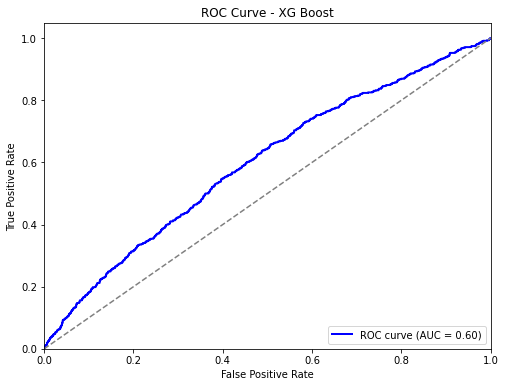

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_xgb_red = xgb_model_red.predict_proba(X_test_reducido)[:, 1]

fpr_xgb_red, tpr_xgb_red, thresholds_xgb_red = roc_curve(y_test, y_prob_xgb_red)

auc_xgb_red = roc_auc_score(y_test, y_prob_xgb_red)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_red, tpr_xgb_red, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_xgb_red)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XG Boost')
plt.legend(loc='lower right')
plt.show()

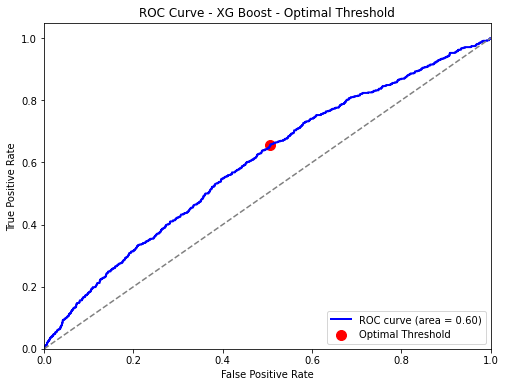

Optimal Threshold: 0.03404455


In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_xgb_red = xgb_model_red.predict_proba(X_test_reducido)[:, 1]

fpr_xgb_red, tpr_xgb_red, thresholds_xgb_red = roc_curve(y_test, y_prob_xgb_red)

auc_xgb_red = roc_auc_score(y_test, y_prob_xgb_red)

Youden_index_xgb_red = tpr_xgb_red - fpr_xgb_red
optimal_threshold_index_xgb_red = np.argmax(Youden_index_xgb_red)
optimal_threshold_xgb_red = thresholds_xgb_red[optimal_threshold_index_xgb_red]

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_red, tpr_xgb_red, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc_xgb_red)
plt.scatter(fpr_xgb_red[optimal_threshold_index_xgb_red], tpr_xgb_red[optimal_threshold_index_xgb_red], color='red', s=100, label='Optimal Threshold')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XG Boost - Optimal Threshold')
plt.legend(loc='lower right')
plt.show()

print("Optimal Threshold:", optimal_threshold_xgb_red)

In [66]:
from sklearn.metrics import confusion_matrix

y_prob_xgb_red = xgb_model_red.predict_proba(X_test_reducido)[:, 1]

y_pred_optimal_xgb_red = (y_prob_xgb_red >= optimal_threshold_xgb_red).astype(int)

conf_matrix_xgb_red = confusion_matrix(y_test, y_pred_optimal_xgb_red)

print("Matriz de Confusión:")
print(conf_matrix_xgb_red)

Matriz de Confusión:
[[6057 6220]
 [ 202  388]]


In [67]:
y_prob_xgb_red = xgb_model_red.predict_proba(X_test_reducido)[:, 1]
y_pred_xgb_red = xgb_model_red.predict(X_test_reducido)
y_pred_optimal_xgb_red = (y_prob_xgb_red >= optimal_threshold_xgb_red).astype(int)


result_df_red = pd.DataFrame({'y_prob': y_prob_xgb_red
                              , 'y_pred': y_pred_xgb_red
                              , 'y_pred_OT':y_pred_optimal_xgb_red }
                             , index=X_test.index)
result_df_red

,y_prob,y_pred,y_pred_OT
16695,0.113864,0,1
40222,0.009087,0,0
33953,0.037112,0,1
42452,0.014778,0,0
18606,0.037792,0,1
...,...,...,...
26626,0.049397,0,1
6494,0.055331,0,1
3234,0.041254,0,1
28370,0.015980,0,0


In [68]:
file_name = 'predicciones.xlsx'
result_df_red.to_excel(file_name)

In [69]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real_xgb_red, y_prob_xgb_red):
    df = pd.DataFrame()
    df['real'] = y_real_xgb_red
    df['proba'] = y_prob_xgb_red
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'], df['proba'])
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    return ks.statistic, roc_auc

print("xgb_red model:")
ks_xgb_red, auc_xgb_red = evaluate_ks_and_roc_auc(y_test, y_prob_xgb_red)

xgb_red model:
KS: 0.1510 (p-value: 1.137e-11)
ROC AUC: 0.5973


In [70]:
results_df_xgb_red = pd.DataFrame({
    'Modelo': ['XGBoost Reducido'],
    'KS': [ks_xgb_red],
    'ROC AUC': [auc_xgb_red]
})

results_resumen_red = pd.concat([results_df_log_red, results_df_rf_red,results_df_xgb_red ], ignore_index=True)
results_resumen_red = results_resumen_red.round(3)
results_resumen_red

,Modelo,KS,ROC AUC
0,Logistico Reducido,0.112,0.563
1,Random Forest Reducido,0.089,0.553
2,XGBoost Reducido,0.151,0.597


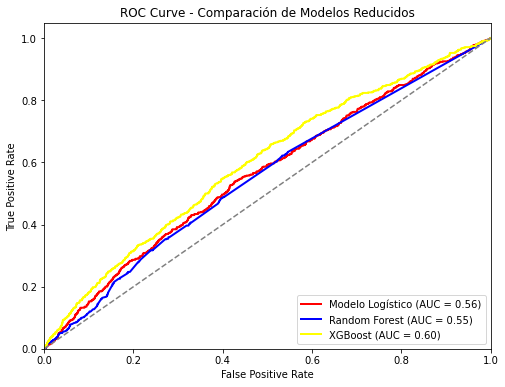

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Curva ROC - Modelo Logístico (SFS)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_red, tpr_log_red, color='red'
         , lw=2, label='Modelo Logístico (AUC = %0.2f)' % auc_log_red)

# Curva ROC - Random Forest
plt.plot(fpr_rf_red, tpr_rf_red, color='blue'
         , lw=2, label='Random Forest (AUC = %0.2f)' % auc_rf_red)

#Curva ROC - XGBoost
plt.plot(fpr_xgb_red, tpr_xgb_red, color='yellow'
         , lw=2, label='XGBoost (AUC = %0.2f)' % auc_xgb_red)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Comparación de Modelos Reducidos')
plt.legend(loc='lower right')
plt.show()

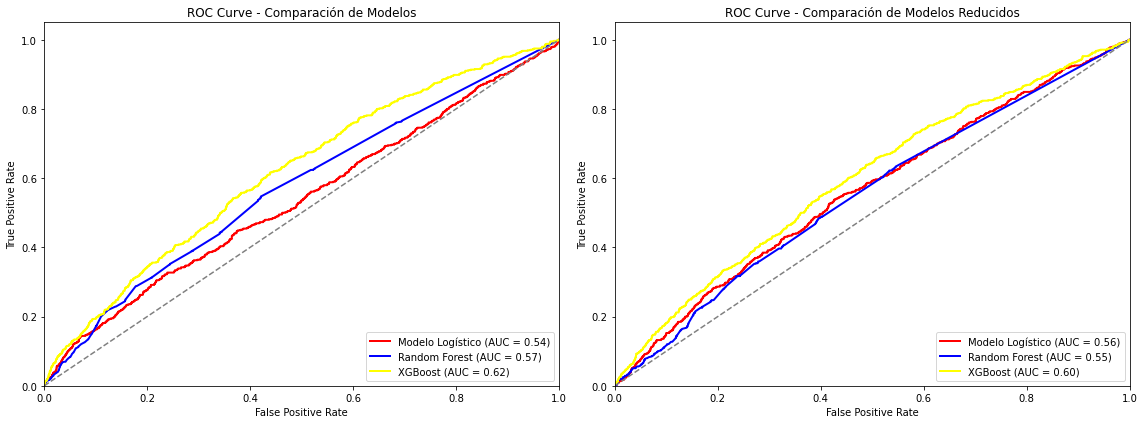

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Crear una figura con dos subgráficos uno al lado del otro
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Primer gráfico - Modelos completos
ax[0].plot(fpr_log, tpr_log, color='red', lw=2, label='Modelo Logístico (AUC = %0.2f)' % auc_log)
ax[0].plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % auc_rf)
ax[0].plot(fpr_xgb, tpr_xgb, color='yellow', lw=2, label='XGBoost (AUC = %0.2f)' % auc_xgb)
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve - Comparación de Modelos')
ax[0].legend(loc='lower right')

# Segundo gráfico - Modelos reducidos (SFS)
ax[1].plot(fpr_log_red, tpr_log_red, color='red', lw=2, label='Modelo Logístico (AUC = %0.2f)' % auc_log_red)
ax[1].plot(fpr_rf_red, tpr_rf_red, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % auc_rf_red)
ax[1].plot(fpr_xgb_red, tpr_xgb_red, color='yellow', lw=2, label='XGBoost (AUC = %0.2f)' % auc_xgb_red)
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve - Comparación de Modelos Reducidos')
ax[1].legend(loc='lower right')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


In [73]:
tabla_resumen = pd.concat([results_resumen , results_resumen_red ], ignore_index=True)
tabla_resumen = tabla_resumen.round(3)
tabla_resumen

,Modelo,KS,ROC AUC
0,Logistico,0.088,0.538
1,Random Forest,0.126,0.574
2,XGBoost,0.178,0.617
3,Logistico Reducido,0.112,0.563
4,Random Forest Reducido,0.089,0.553
5,XGBoost Reducido,0.151,0.597


In [74]:
#OPTIMIZACION DEL PUNTO DE CORTE DEL XGBOOST REDUCIDO

In [75]:
Youden_index_xgb_red = tpr_xgb_red - fpr_xgb_red
optimal_threshold_index_xgb_red = np.argmax(Youden_index_xgb_red)
optimal_threshold_xgb_red = thresholds_xgb_red[optimal_threshold_index_xgb_red]

print("Optimal Threshold:", optimal_threshold_xgb_red)


Optimal Threshold: 0.03404455


In [76]:
y_pred_optimal_xgb_red = (y_prob_xgb_red >= optimal_threshold_xgb_red).astype(int)
y_pred_optimal_xgb_red

array([1, 0, 1, ..., 1, 0, 0])

In [77]:

predicc = pd.DataFrame({'y_prob': y_pred_optimal_xgb_red
                               }
                             , index=X_test.index)
predicc

,y_prob
16695,1
40222,0
33953,1
42452,0
18606,1
...,...
26626,1
6494,1
3234,1
28370,0


In [78]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real_xgb_red, y_proba_xgb_red, y_pred_optimal_xgb_red):
    df = pd.DataFrame()
    df['real'] = y_real_xgb_red
    df['proba'] = y_proba_xgb_red
    df['pred_optimal'] = y_pred_optimal_xgb_red
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    
    # KS usando las probabilidades ajustadas al punto de corte óptimo
    ks = ks_2samp(class0['pred_optimal'], class1['pred_optimal'])
    # AUC 
    roc_auc = roc_auc_score(df['real'], df['proba'])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    return ks.statistic, roc_auc

print("xgb_red model optimizando punto de corte:")
ks_xgb_red, auc_xgb_red = evaluate_ks_and_roc_auc(y_test, y_prob_xgb_red, y_pred_optimal_xgb_red)


xgb_red model optimizando punto de corte:
KS: 0.1510 (p-value: 1.137e-11)
ROC AUC: 0.5973


In [79]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

auc_xgb_opt = roc_auc_score(y_test, y_prob_xgb_red)  

precision_xgb_opt = precision_score(y_test, y_pred_optimal_xgb_red)
recall_xgb_opt = recall_score(y_test, y_pred_optimal_xgb_red)
f1_xgb_opt = f1_score(y_test, y_pred_optimal_xgb_red)
accuracy_xgb_opt = accuracy_score(y_test, y_pred_optimal_xgb_red)

summary_stats = {
    'Métrica': ['AUC', 'Precisión', 'Recall', 'F1-Score', 'Accuracy'],
    'Valor': [auc_xgb_opt, precision_xgb_opt, recall_xgb_opt, f1_xgb_opt, accuracy_xgb_opt]
}

summary_df = pd.DataFrame(summary_stats)
summary_df


,Métrica,Valor
0,AUC,0.597311
1,Precisión,0.058717
2,Recall,0.657627
3,F1-Score,0.107808
4,Accuracy,0.500894


In [80]:
metrics_xgb_red_calib = {
    'AUC': [auc_xgb_opt],
    'Precision': [precision_xgb_opt],
    'Recall': [recall_xgb_opt],
    'F1-score': [f1_xgb_opt],
    'Accuracy': [accuracy_xgb_opt]
}

metrics_df_xgb_red_calib = pd.DataFrame(metrics_xgb_red_calib)
metrics_df_xgb_red_calib = metrics_df_xgb_red_calib.round(3)
metrics_df_xgb_red_calib


,AUC,Precision,Recall,F1-score,Accuracy
0,0.597,0.059,0.658,0.108,0.501


In [81]:
# comparacion de estadisticos

In [82]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from scipy.stats import ks_2samp
import numpy as np

xgb_model_red = xgb.XGBClassifier()
xgb_model_red.fit(X_train_reducido, y_train)

y_prob_xgb_red = xgb_model_red.predict_proba(X_test_reducido)[:, 1]

# punto de corte arbitrario (0.5)
y_pred_arbitrario_xgb_red = (y_prob_xgb_red >= 0.5).astype(int)

auc_xgb_red = roc_auc_score(y_test, y_prob_xgb_red)

def calculate_ks(y_real, y_pred):
    class0 = y_pred[y_real == 0]
    class1 = y_pred[y_real == 1]
    ks = ks_2samp(class0, class1).statistic
    return ks

ks_arbitrario = calculate_ks(y_test, y_prob_xgb_red)


precision_arbitrario = precision_score(y_test, y_pred_arbitrario_xgb_red)
recall_arbitrario = recall_score(y_test, y_pred_arbitrario_xgb_red)
f1_arbitrario = f1_score(y_test, y_pred_arbitrario_xgb_red)
accuracy_arbitrario = accuracy_score(y_test, y_pred_arbitrario_xgb_red)

#punto de corte óptimo
fpr_xgb_red, tpr_xgb_red, thresholds_xgb_red = roc_curve(y_test, y_prob_xgb_red)
youden_index_xgb_red = tpr_xgb_red - fpr_xgb_red
optimal_threshold_index_xgb_red = np.argmax(youden_index_xgb_red)
optimal_threshold_xgb_red = thresholds_xgb_red[optimal_threshold_index_xgb_red]

y_pred_optimal_xgb_red = (y_prob_xgb_red >= optimal_threshold_xgb_red).astype(int)

ks_optimal = calculate_ks(y_test, y_pred_optimal_xgb_red)

precision_optimal = precision_score(y_test, y_pred_optimal_xgb_red)
recall_optimal = recall_score(y_test, y_pred_optimal_xgb_red)
f1_optimal = f1_score(y_test, y_pred_optimal_xgb_red)
accuracy_optimal = accuracy_score(y_test, y_pred_optimal_xgb_red)

metrics_comparison = pd.DataFrame({
    'Métrica': ['AUC', 'Precisión', 'Recall', 'F1-Score', 'Accuracy', 'KS'],
    'Corte Arbitrario (0.5)': [auc_xgb_red, precision_arbitrario, recall_arbitrario, f1_arbitrario, accuracy_arbitrario, ks_arbitrario],
    'Corte Óptimo': [auc_xgb_red, precision_optimal, recall_optimal, f1_optimal, accuracy_optimal, ks_optimal]
})

metrics_comparison


,Métrica,Corte Arbitrario (0.5),Corte Óptimo
0,AUC,0.597311,0.597311
1,Precisión,0.250000,0.058717
2,Recall,0.001695,0.657627
3,F1-Score,0.003367,0.107808
4,Accuracy,0.953991,0.500894
5,KS,0.150989,0.150989


In [83]:
optimal_threshold_xgb_red

0.03404455

In [84]:
#feature importance

In [85]:
feature_importance = xgb_model_red.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
importance_df.index.name = 'Feature'
importance_df.reset_index(inplace=True)

categorical_features = {
    'Canal_ingreso': [
        'Canal_ingreso_Call Center', 
        'Canal_ingreso_Red', 
        'Canal_ingreso_Venta Digital'
    ],
    'departamento': [
        'departamento_Artigas',
        'departamento_Canelones',
        'departamento_Cerro Largo',
        'departamento_Colonia',
        'departamento_Durazno',
        'departamento_Flores',
        'departamento_Florida',
        'departamento_Lavalleja',
        'departamento_Maldonado',
        'departamento_Montevideo',
        'departamento_Paysandú',
        'departamento_Rivera',
        'departamento_Rocha',
        'departamento_Río Negro',
        'departamento_Salto',
        'departamento_San José',
        'departamento_Soriano',
        'departamento_Tacuarembó',
        'departamento_Treinta y Tres'
    ],
    'sexo': [
        'sexo_F',
        'sexo_M'
    ],
    'vuelta_clases': [
        'vuelta_clases_no',
        'vuelta_clases_si'
    ]
}

def map_original_variable(feature_name):
    for original_var, one_hot_columns in categorical_features.items():
        if feature_name in one_hot_columns:
            return original_var
    return feature_name

importance_df['Variable Original'] = importance_df['Feature'].apply(map_original_variable)

grouped_importance = importance_df.groupby('Variable Original')['Importance'].sum().reset_index()

final_importance_df = grouped_importance.sort_values(by='Importance', ascending=False)
final_importance_df

,Variable Original,Importance
2,departamento,24.813978
0,Canal_ingreso,4.478032
5,vuelta_clases,1.613311
3,edad_solicitud,1.511171
4,sexo,1.409757
1,LimiteCredito,1.351791


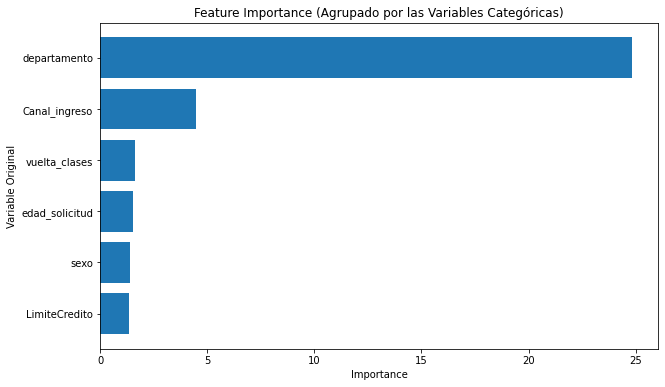

In [86]:
plt.figure(figsize=(10, 6))
plt.barh(final_importance_df['Variable Original'], final_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable Original')
plt.title('Feature Importance (Agrupado por las Variables Categóricas)')
plt.gca().invert_yaxis()
plt.show()

In [87]:
importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
importance_df.index.name = 'Feature'
importance_df.reset_index(inplace=True)

importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
2,Canal_ingreso_Call Center,1.989647
15,departamento_Maldonado,1.860121
9,departamento_Cerro Largo,1.838046
5,vuelta_clases_no,1.613311
23,departamento_Soriano,1.569790
19,departamento_Rocha,1.517632
3,Canal_ingreso_Red,1.512576
0,edad_solicitud,1.511171
21,departamento_Salto,1.503720
18,departamento_Rivera,1.496519


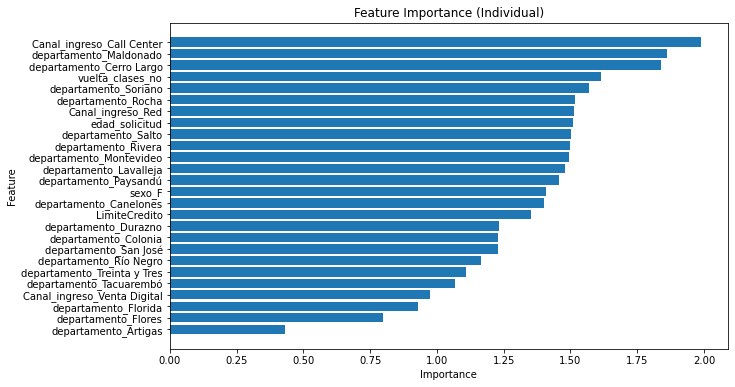

In [88]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Individual)')
plt.gca().invert_yaxis()
plt.show()